## Project Title: Video Classification

### Problem Statment
Human action recognition in video is of interest for applications such as automated surveillance, elderly behavior monitoring, human-computer interaction, content-based video retrieval, and video summarization. For example, in monitoring the activities like drowsiness or fatigue of a driver or not using proper safety measures in Industries.

The main problem with images classification is that we will not be able to detect the continuous action from any images which can be done using video. For example, if someone removes the harness while working in a hazardous situation or a driver yawn continuously 3-4 times while driving. This continuous action will not be able to detect by image classification which is an important action to alarm the person. Video classification can be used for other various purposes like automated surveillance, elderly behavior monitoring or video summarization, and many more.





### Introduction 
We've just worked with photos thus far. We've developed a number of picture categorization, detection, and segmentation models. We've even created new photos out of thin air (noise). Images, on the other hand, are stationary and immobile. Static pictures have no movement. The true delight comes from movement. And here is where videos come in. But what exactly is a video?

The fact is that videos are not that much more difficult to create than photographs. A video is really a series of sequential frames or pictures that are played one after the other. This sequence is seen in the screenshot below:



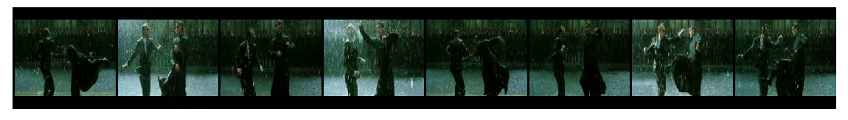

We need to play a particular number of frames per second to create a smooth movie; else, the video would seem fragmented. The majority of the videos we see in our daily lives contain more than 30 frames per second. So you understand the notion now. A short video of 10 seconds would be comparable to 300 photos on that scale. And the abundance of photographs complicates everything.

### Objective

The objective of this study was to build models to perform video classification - one of the most exciting applications of deep learning. 

The dataset considered for this project is the HMDB51 video dataset. A significant portion of the time was spent studying how a video dataset can be loaded, processed, and prepared for its input to the model. In this implementation, the video is split into 16 frames. These frames are stacked; this creates a sample whose shape resembles that of a 5D dataset (i.e. [batch_size, num_of_frames, color_channels, height, width]). In total there are a total of 51 classes. To manage the computation time and resources 4 classes were selected. In the final work, we plan to include a set of pre-defined classes. However, to demonstrate the functioning of the model, 4 classes were selected. The intricate details of the data preparation process and the factors affecting the model performance are highlighted in the later sections.

There are several novel approaches for video classification. The models implemented in this work were inspired by the lab assignments conducted in this course. In addition, certain high-performance models were also explored. The below list summarizes the models implemented.


- **Resnet-18 + LSTM Model:** models.resnet18(pretrained=pretrained) with a combination of LSTM architecture. Both the architectures are a part of the forward function and thus the model weights for both of these networks will be updated during the training process. 

- **Transfer Learning + LSTM + Self-Attention Model:** The first model was modified and learnings from LAB2 were combined to create a new architecture. It was observed that the first model was extremely time-consuming. To exploit the performance of the Resnet18 model, it was not eliminated. Transfer learning was employed. The dataset was first passed onto the pre-trained ResNet model and features were extracted. These features were then saved locally. This too is computationally expensive but should be implemented only once. In this notebook, this approach is demonstrated for four classes. In addition, self-attention mechanism is added alongside the LSTM model to improve the classification performance.

- **Resnet-18 + 3D-CNN Model:** models.video.r3d_18(pretrained=True, progress=False). This model is based on the work presented in this paper (https://arxiv.org/pdf/1711.11248.pdf). Although this concept is not covered in the lectures, we decided to explore its implementation based on its superior performance in the video classification domain. 


**In the duration of this project, some of the steps that were implemented are:**

1. Clean and process the video dataset and create appropriate samples for training the model.
2. Implement and modify high-performance video classification models. In addition, implement hybrid models which exploit the advantages of both the CNN and the RNN architectures.
3. Identify and tune critical hyperparameters to improve model performance (only a few of these iterations are presented in this notebook to limit the computation time and improve the readability of the notebook).
4. Apply transfer learning to reduce time complexity which allows for multiple iterations.
5. Comparative Study of the models on a new test set.

## Importing Libraries
Here, we are importing all the necessary modules for the project.

In [ ]:
import os
import time
import torch
import copy
from tqdm import tqdm
from torchvision.transforms.functional import to_pil_image
import matplotlib.pylab as plt
from torch import nn
from torchvision import models
import cv2
import numpy as np
import torchvision.transforms as transforms
from PIL import Image
from sklearn.model_selection import StratifiedShuffleSplit
from torch.utils.data import Dataset, DataLoader, Subset
import glob
from PIL import Image
import numpy as np
import random
from torch import optim
from torch.optim.lr_scheduler import CosineAnnealingLR, ReduceLROnPlateau


np.random.seed(2020)
random.seed(2020)
torch.manual_seed(2020)

%matplotlib inline

In [ ]:
#defining a general path 
opath = "./trial_30_03/checkpoints"

## Helper Functions
We had created the below helper functions to support the end-to-end pipeline.
1. get_accuracy
2. get_model_name
3. plot_training_curve
4. train_my
5. get_vids
6. denormalize
7. get_frames
8. store_frames

**Note:** The description of functions is given inside the function definition.

In [ ]:
use_cuda = True

def get_accuracy(model, loader, criterion):
    # Function to calculate accuracy of the classification model

    correct = 0
    total = 0
    total_loss = 0
    i = 0

    for imgs, labels in loader:
        
        # To Enable GPU Usage
        if use_cuda and torch.cuda.is_available():
            imgs = imgs.cuda()
            labels = labels.cuda()
        
        output = model(imgs)
        
        # select index with maximum prediction score
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += imgs.shape[0]

        loss = criterion(output, labels)
        total_loss += loss.item()
        i+=1
        
    loss = float(total_loss) / (i)
    acc = correct/total
    
    
    
    return loss, acc

def get_model_name(name, batch_size, learning_rate, epoch):
    # Function to generate path for saving the model
    path = opath + "/model_{0}_bs{1}_lr{2}_epoch{3}_frames{4}.pt".format(name,
                                                   batch_size,
                                                   learning_rate,
                                                   epoch,
                                                   n_frames                
                                                                    )
    
    return path


def plot_training_curve(path): 
    # Function to generate the plots for the respective training iteration
    
    train_acc = np.loadtxt("{}_train_acc.csv".format(path))
    val_acc = np.loadtxt("{}_val_acc.csv".format(path))
    train_loss = np.loadtxt("{}_train_loss.csv".format(path))
    val_loss = np.loadtxt("{}_val_loss.csv".format(path))
    plt.title("Train vs Validation Accuracy")
    n = len(train_acc) # number of epochs
    plt.plot(range(1,n+1), train_acc, label="Train")
    plt.plot(range(1,n+1), val_acc, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.show()
    plt.title("Train vs Validation Loss")
    plt.plot(range(1,n+1), train_loss, label="Train")
    plt.plot(range(1,n+1), val_loss, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()

In [ ]:
#
def train_my(model, train_loader, val_loader, name,  batch_size=64, learning_rate=0.01, num_epochs=30):
    # function is created for custom calling the training function of passed model

    criterion = nn.CrossEntropyLoss()
    #optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
  
    train_acc, val_acc, train_loss, val_loss = [], [], [], []
    
    start_time = time.time()
    
    for epoch in range(num_epochs):
        
            total_train_loss=0
            batch_num=0
            total=0
            correct=0
        
            for imgs, labels in iter(train_loader):
                
                #To Enable GPU Usage
                if use_cuda and torch.cuda.is_available():
                    imgs = imgs.cuda()
                    labels = labels.cuda()
      
                # Zero the parameter gradients
                optimizer.zero_grad()
                # Forward Pass
                
                out = model(imgs)                   
                # Compute Loss
                loss = criterion(out, labels) 
                # Backward Propagation
                loss.backward()               
                #Parameter Updates
                optimizer.step() 
                batch_num+=1 
                
               
                # save the current training information
                total_train_loss += loss.item()
                pred = out.max(1, keepdim=True)[1]
                correct += pred.eq(labels.view_as(pred)).sum().item()
                total += imgs.shape[0]
      
            #Save Loss and accuracy
            train_loss.append(float(total_train_loss) / (batch_num))
            train_acc.append(correct/total) # compute training accuracy 
            with torch.no_grad():
                val_ls, val_ac = get_accuracy(model, loader=val_loader, criterion=criterion)
            val_acc.append(val_ac)  # compute validation accuracy
            val_loss.append(val_ls)

            print(("Epoch {}: Train acc: {}, Train loss: {} |"+
                       "Validation acc: {}, Validation loss: {}").format(
                           epoch + 1,
                           train_acc[epoch],
                           train_loss[epoch],
                           val_acc[epoch],
                           val_loss[epoch]))
    
            # Save the model(checkpoint) to a file in google drive
            model_path = get_model_name(name, batch_size, learning_rate, epoch)
            torch.save(model.state_dict(), model_path)
    
    print('Finished Training')
    end_time = time.time()
    elapsed_time = end_time - start_time
    print("Total time elapsed: {:.2f} seconds".format(elapsed_time))


    print("Final Training Accuracy: {}".format(train_acc[-1]))
    print("Final Validation Accuracy: {}".format(val_acc[-1]))

    # Write the train/test loss/err into CSV file for plotting later
    epochs = np.arange(1, num_epochs + 1)
    np.savetxt("{}_train_acc.csv".format(model_path), train_acc)
    np.savetxt("{}_train_loss.csv".format(model_path), train_loss)
    np.savetxt("{}_val_acc.csv".format(model_path), val_acc)
    np.savetxt("{}_val_loss.csv".format(model_path), val_loss)

    print("The trajectory of the training/validation error and loss:")
    print("--------------------------------------------------------------------------")
    plot_training_curve(model_path)


In [ ]:
def get_vids(path2ajpgs):
    #listdir() method in python is used to get the list of all files and directories in the specified directory.
    listOfCats = os.listdir(path2ajpgs)
    ids = []
    labels = []
    
    for catg in listOfCats:
        path2catg = os.path.join(path2ajpgs, catg)
        listOfSubCats = os.listdir(path2catg)
        path2subCats= [os.path.join(path2catg,los) for los in listOfSubCats]
        ids.extend(path2subCats)
        labels.extend([catg]*len(listOfSubCats))
    return ids, labels, listOfCats 

def denormalize(x_, mean, std):
    x = x_.clone()
    for i in range(3):
        x[i] = x[i]*std[i]+mean[i]
    x = to_pil_image(x)        
    return x


def get_frames(filename, n_frames= 1):
    frames = []
    v_cap = cv2.VideoCapture(filename)
    v_len = int(v_cap.get(cv2.CAP_PROP_FRAME_COUNT))
    frame_list= np.linspace(0, v_len-1, n_frames+1, dtype=np.int16)
    
    for fn in range(v_len):
        success, frame = v_cap.read()
        if success is False:
            continue
        if (fn in frame_list):
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)  
            frames.append(frame)
    v_cap.release()
    return frames, v_len


def store_frames(frames, path2store):
    for ii, frame in enumerate(frames):
        frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)  
        path2img = os.path.join(path2store, "frame"+str(ii)+".jpg")
        cv2.imwrite(path2img, frame)


## Creating the dataset
The first step, as always, is to construct the dataset. To train our model, we'll need a training dataset, and we'll need a test or validation dataset to evaluate it. We will use HMDB for this purpose, which is a big human motion database accessible at [https:/​/​serre-​lab.​clps. brown.​edu/​resource/​hmdb-​a-​large-​human-​motion-​database/​#overview.](https://)

The HMDB dataset was compiled from a variety of sources, including movies, the Prelinger collection, YouTube videos, and Google videos. It is a quite large dataset (2 GB), containing 7,000 video segments in total. There are 51 action classes, each with at least 101 video.

We just showed one frame from each video in the preceding graphic.

We chose four classes to construct a dataset for video classification, and we will turn the videos into photos. Hundreds of frames or photos are used in each video. Processing all of the frames of a movie is not computationally viable. To make things easier, we'll choose 16 frames per movie that are evenly distributed throughout the screen. After that, we'll create a PyTorch dataset class. Following that, we will define PyTorch data loaders for three different types of deep learning models:<br>
- Model 1​: ResNet-18 +LSTM​
- Model 2​: ResNet-18 (3D CNN)​
- Model 3​: Transfer Learning + LSTM + Self-Attention​

For more details on the models, see the below cells.

## Data Preprocessing

Let's watch some videos and turn them into photos. Hundreds of photos may be used in one video. To make things easier, we'll simply take 16 frames that are evenly spaced over the whole video and save them as.jpg files.

### Data Loading

In [ ]:
path2data = "./trial_30_03/data"
sub_folder = "hmdb51_org"
sub_folder_jpg = "hmdb51_jpg"
path2aCatgs = os.path.join(path2data, sub_folder)
print("The total no. of categories are 51 in the entire dataset")
print("The Categories included in the study are: ")
listOfCategories = os.listdir(path2aCatgs)
listOfCategories, len(listOfCategories)


The total no. of categories are 51 in the entire dataset
The Categories included in the study are: 


(['laugh', 'run', 'shake_hands', 'turn'], 4)

### Number of Folders in each category

In [ ]:
for cat in listOfCategories:
    print("category:", cat)
    path2acat = os.path.join(path2aCatgs, cat)
    listOfSubs = os.listdir(path2acat)
    print("number of sub-folders:", len(listOfSubs))
    print("-"*50)

category: laugh
number of sub-folders: 193
--------------------------------------------------
category: run
number of sub-folders: 210
--------------------------------------------------
category: shake_hands
number of sub-folders: 202
--------------------------------------------------
category: turn
number of sub-folders: 216
--------------------------------------------------


### Converting the videos to Frames

**It was learned that the no. of frames plays a major role in the video classification task.** If time permits and based on the time complexity we aim to experiment with the performance of the model concerning the number of frames. 

The following cell loads and saves the frames of each video to the respective folder.

In [ ]:
extension = ".avi"
n_frames = 16
for root, dirs, files in os.walk(path2aCatgs, topdown=False):
    for name in files:
        if extension not in name:
            continue
        path2vid = os.path.join(root, name)
        frames, vlen = get_frames(path2vid, n_frames= n_frames)
        path2store = path2vid.replace(sub_folder, sub_folder_jpg)
        path2store = path2store.replace(extension, "")
        print(path2store)
        os.makedirs(path2store, exist_ok= True)
        store_frames(frames, path2store)
    print("-"*50)    

'\nextension = ".avi"\nn_frames = 16\nfor root, dirs, files in os.walk(path2aCatgs, topdown=False):\n    for name in files:\n        if extension not in name:\n            continue\n        path2vid = os.path.join(root, name)\n        frames, vlen = get_frames(path2vid, n_frames= n_frames)\n        path2store = path2vid.replace(sub_folder, sub_folder_jpg)\n        path2store = path2store.replace(extension, "")\n        print(path2store)\n        os.makedirs(path2store, exist_ok= True)\n        store_frames(frames, path2store)\n    print("-"*50)    \n'

## Data Splitting

We transformed the videos into images in the previous part, Data Preprocessing. We grabbed 16 frames from each video. We will divide the dataset into training and validation sets here.

In [ ]:
path2ajpgs = os.path.join(path2data, sub_folder_jpg)

In [ ]:
all_vids, all_labels, catgs = get_vids(path2ajpgs) 
print("The shape of the dataset is: ", len(all_vids), len(all_labels), len(catgs))

The shape of the dataset is:  804 804 4


In [ ]:
labels_dict = {}
ind = 0
for uc in catgs:
    labels_dict[uc] = ind
    ind+=1

    
print("The labels for the categories are: ", labels_dict)

The labels for the categories are:  {'laugh': 0, 'run': 1, 'shake_hands': 2, 'turn': 3}


In this implementation, four classes are considered.

In [ ]:
num_classes = 4

unique_ids = [id_ for id_, label in zip(all_vids,all_labels) if labels_dict[label]<num_classes]
unique_labels = [label for id_, label in zip(all_vids,all_labels) if labels_dict[label]<num_classes]
print("Length of unique ids: {}, Length of unique labels: {}".format(len(unique_ids),len(unique_labels)))

Length of unique ids: 804, Length of unique labels: 804


In [ ]:

sss = StratifiedShuffleSplit(n_splits=2, test_size=0.1, random_state=0)
train_indx, test_indx = next(sss.split(unique_ids, unique_labels))

print("Training Samples:")
train_ids = [unique_ids[ind] for ind in train_indx]
train_labels = [unique_labels[ind] for ind in train_indx]
print(len(train_ids), len(train_labels)) 

print("Validation Samples:")
test_ids = [unique_ids[ind] for ind in test_indx]
test_labels = [unique_labels[ind] for ind in test_indx]
print(len(test_ids), len(test_labels))

Training Samples:
723 723
Validation Samples:
81 81


## Defining Dataset

In the previous section, Data Splitting, we split the data into training and validation sets. Here, we will define a PyTorch dataset class. Then, we will instantiate two objects of the class for the training and validation datasets.


In [ ]:
class VideoDataset(Dataset):
    def __init__(self, ids, labels, transform):      
        self.transform = transform
        self.ids = ids
        self.labels = labels
    def __len__(self):
        return len(self.ids)
    def __getitem__(self, idx):
        path2imgs=glob.glob(self.ids[idx]+"/*.jpg")
        path2imgs = path2imgs[:timesteps]
        label = labels_dict[self.labels[idx]]
        frames = []
        for p2i in path2imgs:
            frame = Image.open(p2i)
            frames.append(frame)
        
        seed = np.random.randint(1e9)        
        frames_tr = []
        for frame in frames:
            random.seed(seed)
            np.random.seed(seed)
            frame = self.transform(frame)
            frames_tr.append(frame)
        if len(frames_tr)>0:
            frames_tr = torch.stack(frames_tr)
        return frames_tr, label

In [ ]:
def collate_fn_rnn(batch):
    imgs_batch, label_batch = list(zip(*batch))
    imgs_batch = [imgs for imgs in imgs_batch if len(imgs)>0]
    label_batch = [torch.tensor(l) for l, imgs in zip(label_batch, imgs_batch) if len(imgs)>0]
    imgs_tensor = torch.stack(imgs_batch)
    labels_tensor = torch.stack(label_batch)
    return imgs_tensor,labels_tensor

In [ ]:
# The number of frames/timesteps

timesteps = 16

In [ ]:
# Parameters for Transform

h, w = 64, 64
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

The transforms were applied to the training set. To improve the generalization capabilities of the model horizontal flips and translations of images were induced for the training datasets. 

In [ ]:
# Data Transformartion

train_transformer = transforms.Compose([
            transforms.Resize((h,w)),
            transforms.RandomHorizontalFlip(p=1.0),  
            transforms.RandomAffine(degrees=0, translate=(0.1,0.1)),    
            transforms.ToTensor(),
            transforms.Normalize(mean, std),
            ])  

In [ ]:
# Generating the training dataset 

train_ds = VideoDataset(ids= train_ids, labels= train_labels, transform= train_transformer)
print("The length of the training dataset is: ", len(train_ds))

The length of the training dataset is:  723


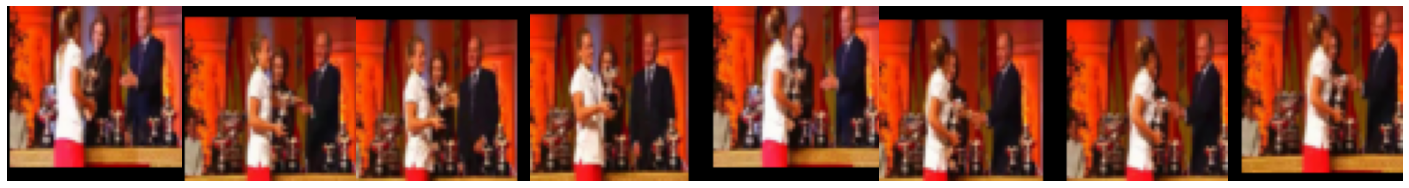

In [ ]:
# sample data processed for train video

imgs, label = train_ds[208]
imgs.shape, label, torch.min(imgs), torch.max(imgs)

plt.figure(figsize=(50,20))
plt.subplots_adjust(wspace=0, hspace=0)
for ii,img in enumerate(imgs[::2]):
    
    plt.subplot(1,16,ii+1)
    plt.imshow(denormalize(img, mean, std))
    plt.axis("off")

In [ ]:
test_transformer = transforms.Compose([
            transforms.Resize((h,w)),
            transforms.ToTensor(),
            transforms.Normalize(mean, std),
            ]) 
test_ds = VideoDataset(ids= test_ids, labels= test_labels, transform= test_transformer)
print("The length of the test dataset is: ", len(test_ds))

The length of the test dataset is:  81


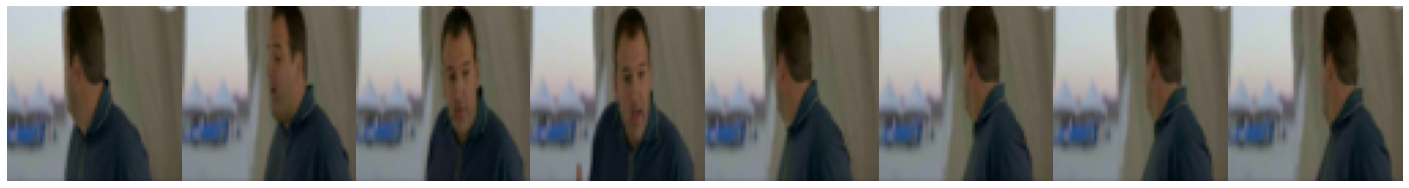

In [ ]:
# sample data processed for validation video

imgs, label = test_ds[5]
imgs.shape, label, torch.min(imgs), torch.max(imgs)

plt.figure(figsize=(50,20))
plt.subplots_adjust(wspace=0, hspace=0)
for ii,img in enumerate(imgs[::2]):
    plt.subplot(1,16,ii+1)
    plt.imshow(denormalize(img, mean, std))
    plt.axis("off")

## End-to-End Pipeline
The first step of the pipeline was the extraction of frames from the videos. The extracted images were then split into train/validation sets, appropriately transformed, and fed to the classification model. The model was trained by iterating over several hyperparameters based on the model architecture, and the model with the best performance on the validation set was selected for further evaluation.

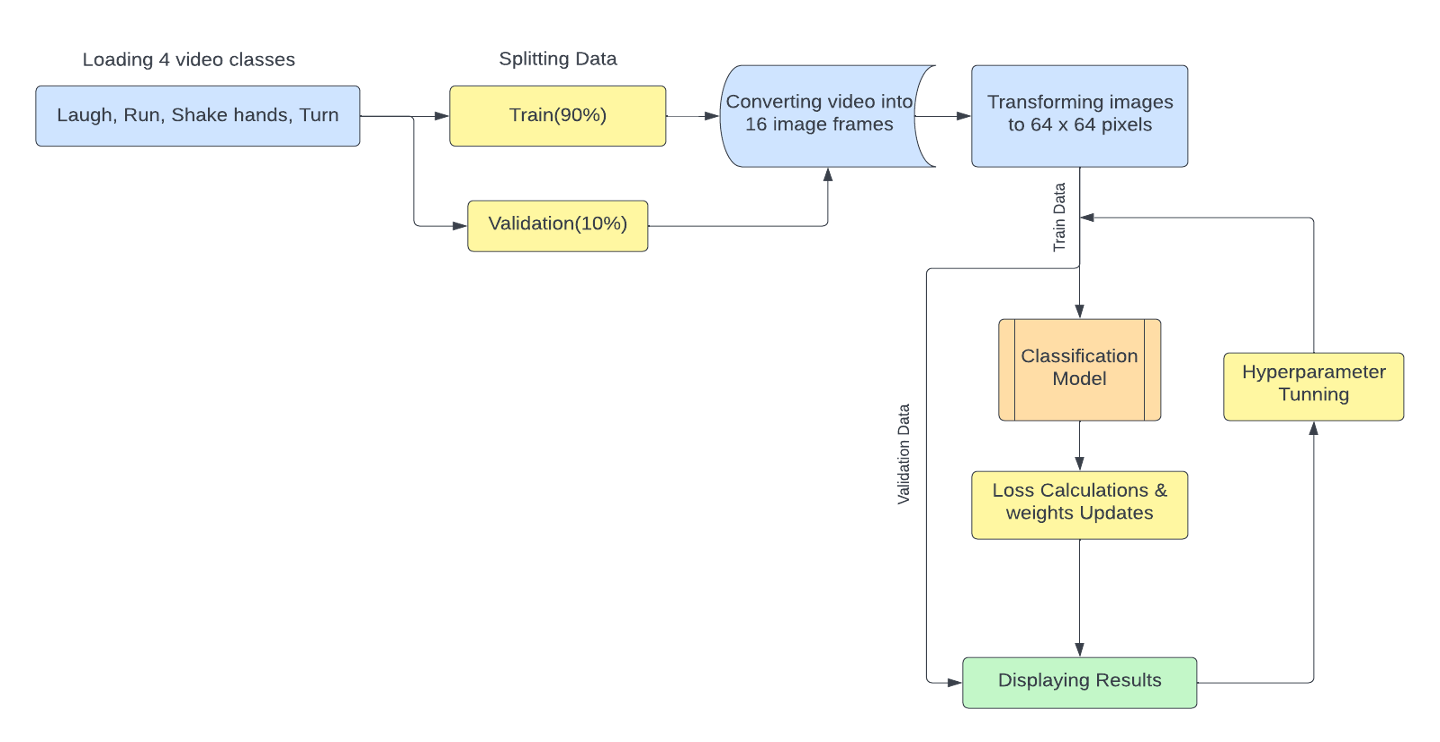

## Defining the models

Three architectures were explored based on the learnings from the course. The first model was a combination of ResNet-18 and LSTM architecture. As the 2D convolutions cannot handle sequential datasets at once, one frame was inputted at a time. In addition, a 3D CNN network from the literature was implemented for comparative study. Apart from these models, another alternative to the first model was created. Instead of keeping the ResNet-18 architecture in the training loop, it was just for extracting features through transfer learning. These features were then supplied to a shallow network which comprised of an LSTM architecture combined with a self-attention mechanism as presented below.

### Model 1: Resnet18 + LSTM

This model is a combination of the Resnet18 model which implements a 2D convolution over the provided images and an LSTM network to account for the time dependency of each frame. It can be noted that the shape of the sample is a 5D dataset. In order to extract features from the Resnet model, each frame of the video is supplied one by one as it can only handle an input of the shape [batch size, color channels, height, width]. The flow of the model is presented below.

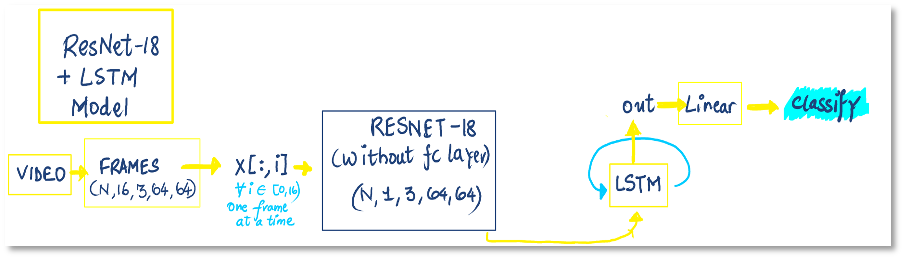

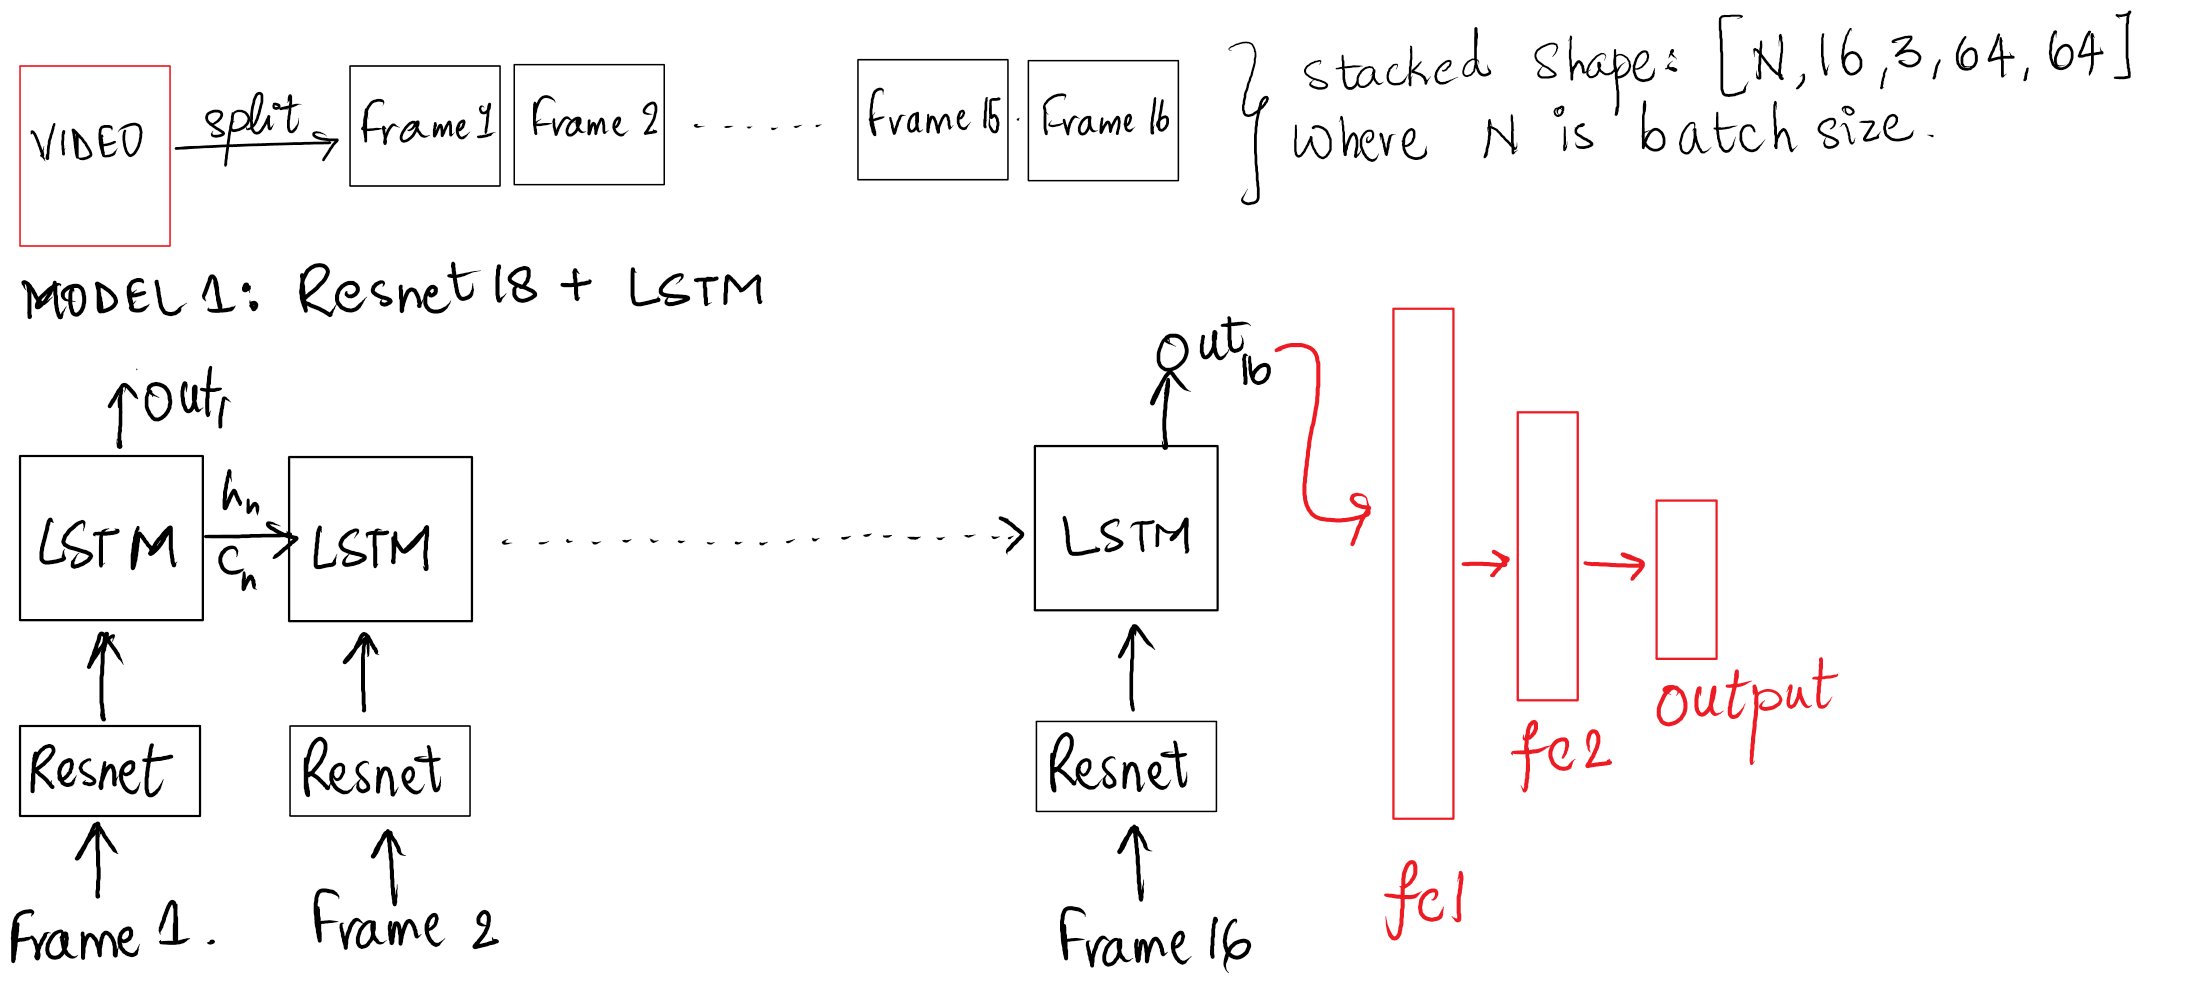


In [ ]:
class Resnt18Rnn(nn.Module):
    def __init__(self, params_model):
        super(Resnt18Rnn, self).__init__()
        num_classes = params_model["num_classes"]
        dr_rate= params_model["dr_rate"]
        pretrained = params_model["pretrained"]
        rnn_hidden_size = params_model["rnn_hidden_size"]
        rnn_num_layers = params_model["rnn_num_layers"]
        
        baseModel = models.resnet18(pretrained=pretrained)
        num_features = baseModel.fc.in_features
        baseModel.fc = Identity()
        self.baseModel = baseModel
        self.dropout= nn.Dropout(dr_rate)
        self.rnn = nn.LSTM(num_features, rnn_hidden_size, rnn_num_layers)
        self.fc1 = nn.Linear(rnn_hidden_size, num_classes)
        #self.name = 'Resnt18Rnn'
        
    def forward(self, x):
        b_z, ts, c, h, w = x.shape
        ii = 0
        y = self.baseModel((x[:,ii]))
        output, (hn, cn) = self.rnn(y.unsqueeze(1))
        for ii in range(1, ts):
            y = self.baseModel((x[:,ii]))
            out, (hn, cn) = self.rnn(y.unsqueeze(1), (hn, cn))
        out = self.dropout(out[:,-1])
        out = self.fc1(out) 
        return out 
    
class Identity(nn.Module):
    def __init__(self):
        super(Identity, self).__init__()
    def forward(self, x):
        return x    

In [ ]:
batch_size=16
train_dl = DataLoader(train_ds, batch_size= batch_size, shuffle=True, collate_fn= collate_fn_rnn)
test_dl = DataLoader(test_ds, batch_size= 2*batch_size, shuffle=False, collate_fn= collate_fn_rnn)  

In [ ]:
params_model={
        "num_classes": num_classes,
        "dr_rate": 0.1,
        "pretrained" : True,
        "rnn_num_layers": 1,
        "rnn_hidden_size": 100,}

model = Resnt18Rnn(params_model)  
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

model

Resnt18Rnn(
  (baseModel): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, trac

**Training the Model 1**

Epoch 1: Train acc: 0.3983402489626556, Train loss: 1.3105624965999438 |Validation acc: 0.5925925925925926, Validation loss: 1.162441333134969
Epoch 2: Train acc: 0.6721991701244814, Train loss: 1.0197319505007372 |Validation acc: 0.654320987654321, Validation loss: 0.9430283308029175
Epoch 3: Train acc: 0.6984785615491009, Train loss: 0.8461561488068622 |Validation acc: 0.691358024691358, Validation loss: 0.8195461432139078
Epoch 4: Train acc: 0.7662517289073306, Train loss: 0.6978085416814556 |Validation acc: 0.7160493827160493, Validation loss: 0.7453407347202301
Epoch 5: Train acc: 0.7966804979253111, Train loss: 0.6183351336613946 |Validation acc: 0.7160493827160493, Validation loss: 0.6924569805463155
Epoch 6: Train acc: 0.8395573997233748, Train loss: 0.5340739968030349 |Validation acc: 0.7530864197530864, Validation loss: 0.6261186202367147
Epoch 7: Train acc: 0.8506224066390041, Train loss: 0.4867315891644229 |Validation acc: 0.7283950617283951, Validation loss: 0.640727500120

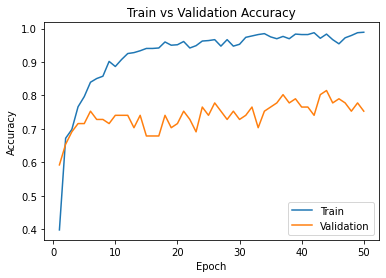

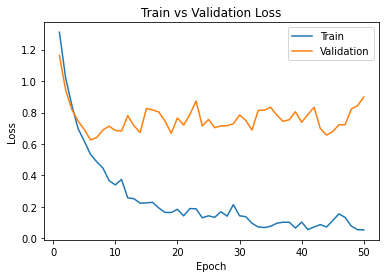

In [ ]:
train_my(model, train_dl, test_dl, name='CNN_LSTM', batch_size=batch_size, learning_rate=0.0001, num_epochs=50)

### Model 2: ResNet-18 3D-CNN


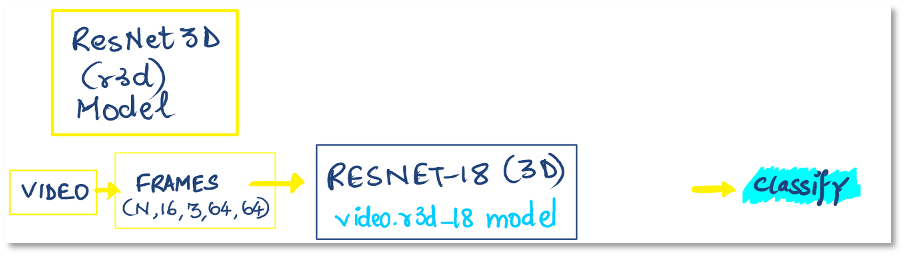

Reference: https://arxiv.org/pdf/1711.11248.pdf. This link is also specified in the PyTorch documentation. In this work, a spatiotemporal convolutional block R(2+1)D is presented. Although the model is not explored in the lectures, we were eager to see its performance on the considered dataset. Without much tuning, superior performance was achieved in this case. A study will be explored to generate in-depth insights on the model performance in the upcoming submissions.

In [ ]:
def collate_fn_r3d_18(batch):
    imgs_batch, label_batch = list(zip(*batch))
    imgs_batch = [imgs for imgs in imgs_batch if len(imgs)>0]
    label_batch = [torch.tensor(l) for l, imgs in zip(label_batch, imgs_batch) if len(imgs)>0]
    imgs_tensor = torch.stack(imgs_batch)
    imgs_tensor = torch.transpose(imgs_tensor, 2, 1)
    labels_tensor = torch.stack(label_batch)
    return imgs_tensor,labels_tensor

In [ ]:
h, w = 64, 64
mean = [0.43216, 0.394666, 0.37645]
std = [0.22803, 0.22145, 0.216989]

In [ ]:
train_transformer = transforms.Compose([
            transforms.Resize((h,w)),
            transforms.RandomHorizontalFlip(p=0.5),  
            transforms.RandomAffine(degrees=0, translate=(0.1,0.1)),    
            transforms.ToTensor(),
            transforms.Normalize(mean, std),
            ])  

train_ds_3d = VideoDataset(ids= train_ids, labels= train_labels, transform= train_transformer)


test_transformer = transforms.Compose([
            transforms.Resize((h,w)),
            transforms.ToTensor(),
            transforms.Normalize(mean, std),
            ]) 

test_ds_3d = VideoDataset(ids= test_ids, labels= test_labels, transform= test_transformer)



In [ ]:
train_dl_3d = DataLoader(train_ds_3d, batch_size= batch_size, 
                          shuffle=True, collate_fn= collate_fn_r3d_18)
test_dl_3d = DataLoader(test_ds_3d, batch_size= 2*batch_size, 
                         shuffle=False, collate_fn= collate_fn_r3d_18)     

In [ ]:
model_3 = models.video.r3d_18(pretrained=True, progress=False)
num_features = model_3.fc.in_features
model_3.fc = nn.Linear(num_features, num_classes)

In [ ]:

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_3 = model_3.to(device)

model_3

VideoResNet(
  (stem): BasicStem(
    (0): Conv3d(3, 64, kernel_size=(3, 7, 7), stride=(1, 2, 2), padding=(1, 3, 3), bias=False)
    (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Sequential(
        (0): Conv3DSimple(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
        (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
      )
      (conv2): Sequential(
        (0): Conv3DSimple(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
        (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (relu): ReLU(inplace=True)
    )
    (1): BasicBlock(
      (conv1): Sequential(
        (0): Conv3DSimple(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
        (1):

**Training the Model 3**

Epoch 1: Train acc: 0.34163208852005533, Train loss: 1.5315015264179395 |Validation acc: 0.2839506172839506, Validation loss: 1.3349430163701375
Epoch 2: Train acc: 0.318118948824343, Train loss: 1.4083670947862708 |Validation acc: 0.41975308641975306, Validation loss: 1.2234159310658772
Epoch 3: Train acc: 0.3817427385892116, Train loss: 1.288152813911438 |Validation acc: 0.38271604938271603, Validation loss: 1.2313369909922283
Epoch 4: Train acc: 0.43568464730290457, Train loss: 1.2335104501765708 |Validation acc: 0.4567901234567901, Validation loss: 1.1413938999176025
Epoch 5: Train acc: 0.3582295988934993, Train loss: 1.269514393547307 |Validation acc: 0.4074074074074074, Validation loss: 1.1918944517771404
Epoch 6: Train acc: 0.41770401106500693, Train loss: 1.2652565953524217 |Validation acc: 0.41975308641975306, Validation loss: 1.1572599212328594
Epoch 7: Train acc: 0.4107883817427386, Train loss: 1.1998762268087138 |Validation acc: 0.48148148148148145, Validation loss: 0.99509

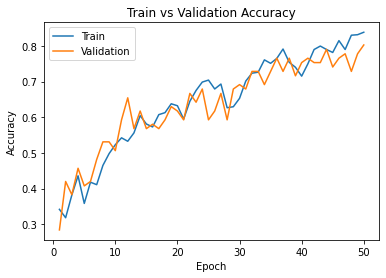

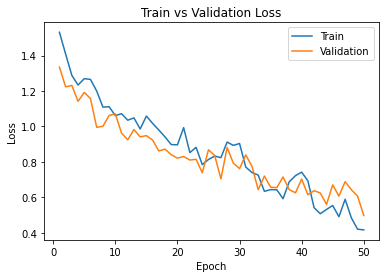

In [ ]:
train_my(model_3, train_dl, test_dl, name='VideoResNet', batch_size=batch_size, learning_rate=0.0015, num_epochs=50)

Epoch 1: Train acc: 0.3084370677731674, Train loss: 1.388154869494231 |Validation acc: 0.2962962962962963, Validation loss: 1.3756017684936523
Epoch 2: Train acc: 0.4508990318118949, Train loss: 1.2512492978054544 |Validation acc: 0.48148148148148145, Validation loss: 1.3136145671208699
Epoch 3: Train acc: 0.5947441217150761, Train loss: 1.1448622475499692 |Validation acc: 0.41975308641975306, Validation loss: 1.258542497952779
Epoch 4: Train acc: 0.6749654218533887, Train loss: 1.0480202721512837 |Validation acc: 0.49382716049382713, Validation loss: 1.1696306467056274
Epoch 5: Train acc: 0.7261410788381742, Train loss: 0.953915782596754 |Validation acc: 0.5555555555555556, Validation loss: 1.1216400861740112
Epoch 6: Train acc: 0.7759336099585062, Train loss: 0.8718661147615184 |Validation acc: 0.5679012345679012, Validation loss: 1.073145826657613
Epoch 7: Train acc: 0.8132780082987552, Train loss: 0.8018862086793651 |Validation acc: 0.6296296296296297, Validation loss: 1.0161070823

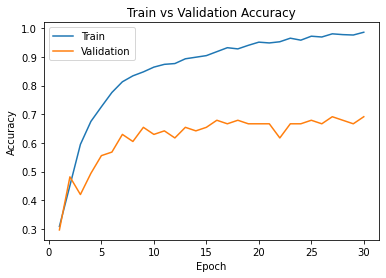

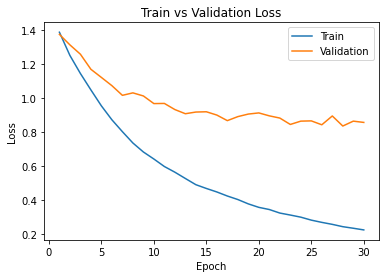

In [ ]:
itr = 301
batch_size = 32
hidden_size = 128
lr_rate = 0.00001
n_layers = 20
dr = 0.05


train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


params_model={
        "num_classes": num_classes,
        "dr_rate": dr,
        "pretrained" : True,
        "rnn_num_layers": 1,
        "rnn_hidden_size": hidden_size,}

model_1 = LSTM_Model_reverse(params_model)  
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_1 = model_1.to(device)

train_my(model_1, train_loader, test_loader, name='{}_LSTM2_rev_best_h{}_n{}_dr{}'.format(itr, hidden_size, n_layers, dr), 
         batch_size=batch_size, learning_rate=lr_rate, num_epochs=30)


### Model 3: Feature Learning + LSTM + Self Attention

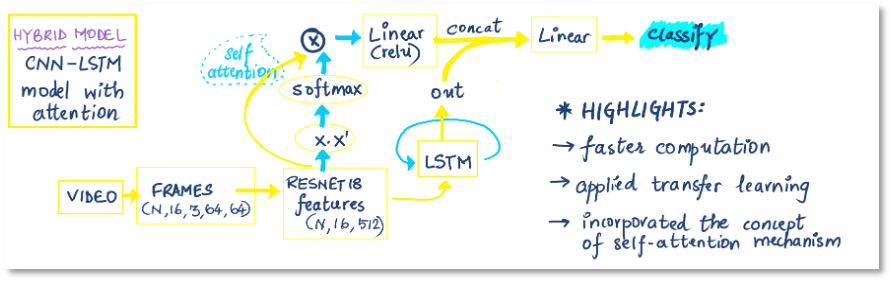

In this experimentation, only LSTM is used. The Resnet18 model is applied just for the extraction of features similar to what was learned in the transfer learning section of Lab2. The input to the LSTM now would be the features of shape [N, n_frames, 512]. This helps improve the time complexity of the model at the expense of model performance. It was observed that the extraction of features is extremely time-consuming. Hence, in this work, only two classes are selected for demonstration of the functioning of the model. In the next submission, we would focus on exploring the performance of the model on the selected dataset. 

It was also noted that with the current small dataset, the model works as a sanity check. 

In addition, a self-attention mechanism is in the works. To improve the model performance, we can point out that not all the frames are critical to the video classification task. A self-attention mechanism could be employed to determine critical features from the input space and use it along with the LSTM output as an input to the fully connected layer.

In [ ]:

import torch.nn.functional as F

class LSTM_Model_reverse(nn.Module):
    def __init__(self, params_model):
        super(LSTM_Model_reverse, self).__init__()
        num_classes = params_model["num_classes"]
        dr_rate= params_model["dr_rate"]
        pretrained = params_model["pretrained"]
        rnn_hidden_size = params_model["rnn_hidden_size"]
        rnn_num_layers = params_model["rnn_num_layers"]
              
        num_features = 512
        
        self.dropout= nn.Dropout(dr_rate)
        
        self.rnn = nn.LSTM(num_features, rnn_hidden_size, rnn_num_layers, batch_first=True)
        self.fc1 = nn.Linear(rnn_hidden_size*2, num_classes)
        self.attlinear = nn.Linear(8192, rnn_hidden_size)
        #self.attlinear1 = nn.Linear(2048, rnn_hidden_size)
        self.act = nn.ReLU()
        
    def forward(self, x):
        b_z, ts, n_f = x.shape
        ii = 0
        y = x[:,ii]
        
        #print(x.shape)
        #Experimented Self-Attention Mechanism
        rw = torch.bmm(x, x.transpose(1,2))
        #rw = torch.bmm(x.transpose(1,2), x)
        w = F.softmax(rw,dim=2)
        
        y11 = torch.bmm(w, x)
        #y11 = torch.bmm(x,w)
        
        #y_mean = torch.mean(y11, dim=1, keepdim=True)
        
        output, (hn, cn) = self.rnn(y.unsqueeze(1))
        
        for ii in range(1, ts):
            y = x[:,ii]
            out, (hn, cn) = self.rnn(y.unsqueeze(1), (hn, cn))
        
        
        ox = y11.view(-1, 8192)
        
        ox = self.act(self.attlinear(ox))
        #ox = self.act(self.attlinear1(ox))
        
        out = torch.cat((out, ox.unsqueeze(dim=1)), dim=2)
        out = self.dropout(out[:,-1])
        
        out = self.fc1(out.squeeze(dim=1)) 
        
        
        return out 
    
class Identity(nn.Module):
    def __init__(self):
        super(Identity, self).__init__()
    def forward(self, x):
        return x    

In [ ]:
train_dl_f = DataLoader(train_ds, batch_size= 2048,
                          shuffle=False, collate_fn= collate_fn_rnn)
test_dl_f = DataLoader(test_ds, batch_size= 2048,
                         shuffle=False, collate_fn= collate_fn_rnn) 

In [ ]:
baseModel_c = models.resnet18(pretrained=True)
baseModel_c.fc = Identity()

from tqdm import tqdm
for xb1, yb1 in tqdm(train_dl_f):
    b_z, ts, c, h, w = xb1.shape
    ch = 0
    for ii in range(0, ts):
        if ch==0:
            y_tr = baseModel_c((xb1[:,ii])).unsqueeze(dim=1)
            
        else:
            
            y1_tr = baseModel_c((xb1[:,ii])).unsqueeze(dim=1)
            y_tr = torch.cat((y_tr,y1_tr), dim=1)

        ch+=1
    ybb_tr = yb1

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [01:27<00:00, 87.77s/it]


In [ ]:
print('Train Features shape: {}, Labels shape: {}'.format(y_tr.shape, ybb_tr.shape))
torch.save(y_tr, './trial_30_03/features/train_features_4.pt')
torch.save(ybb_tr, './trial_30_03/features/train_labels_4.pt')

Train Features shape: torch.Size([723, 16, 512]), Labels shape: torch.Size([723])


In [ ]:
for xb2, yb2 in test_dl_f:
    b_z, ts, c, h, w = xb2.shape
    ch = 0
    for ii in range(0, ts):
        if ch==0:
            y_ts = baseModel_c((xb2[:,ii])).unsqueeze(dim=1)
            
        else:
            
            y1_ts = baseModel_c((xb2[:,ii])).unsqueeze(dim=1)
            y_ts = torch.cat((y_ts,y1_ts), dim=1)

        ch+=1
    ybb_ts = yb2 

In [ ]:
print('Test Features shape: {}, Labels shape: {}'.format(y_ts.shape, ybb_ts.shape))
torch.save(y_ts, './trial_30_03/features/test_features_4.pt')
torch.save(ybb_ts, './trial_30_03/features/test_labels_4.pt')

Test Features shape: torch.Size([81, 16, 512]), Labels shape: torch.Size([81])


In [ ]:
load_train_features = torch.load('./trial_30_03/features/train_features_4.pt')
load_train_labels = torch.load('./trial_30_03/features/train_labels_4.pt')

load_test_features = torch.load('./trial_30_03/features/test_features_4.pt')
load_test_labels = torch.load('./trial_30_03/features/test_labels_4.pt')

In [ ]:
from torch.utils.data import TensorDataset, Dataset
#All required data defined globally in transfer learning section
train_dataset = TensorDataset(load_train_features, load_train_labels)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    
test_dataset = TensorDataset(load_test_features, load_test_labels)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


**Training the Model 2, with different hyperparameters.**

Epoch 1: Train acc: 0.3236514522821577, Train loss: 2.858028789361318 |Validation acc: 0.25925925925925924, Validation loss: 1.9421205520629883
Epoch 2: Train acc: 0.44398340248962653, Train loss: 1.2453978061676025 |Validation acc: 0.48148148148148145, Validation loss: 1.2208847999572754
Epoch 3: Train acc: 0.6763485477178424, Train loss: 0.7697730859120687 |Validation acc: 0.5925925925925926, Validation loss: 1.1344897747039795
Epoch 4: Train acc: 0.7869986168741355, Train loss: 0.5646724998950958 |Validation acc: 0.6790123456790124, Validation loss: 0.8864783048629761
Epoch 5: Train acc: 0.8769017980636238, Train loss: 0.39667225380738574 |Validation acc: 0.654320987654321, Validation loss: 0.9007948040962219
Epoch 6: Train acc: 0.921161825726141, Train loss: 0.28244269142548245 |Validation acc: 0.6296296296296297, Validation loss: 0.8980630040168762
Epoch 7: Train acc: 0.9640387275242047, Train loss: 0.17623219887415567 |Validation acc: 0.6296296296296297, Validation loss: 0.892617

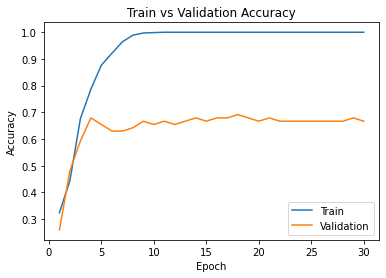

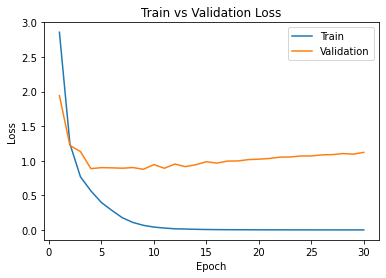

In [ ]:
itr = 201
batch_size = 128
hidden_size = 150
lr_rate = 0.0015
n_layers = 1
dr = 0


train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


params_model={
        "num_classes": num_classes,
        "dr_rate": dr,
        "pretrained" : True,
        "rnn_num_layers": 1,
        "rnn_hidden_size": hidden_size,}

model_1 = LSTM_Model_reverse(params_model)  
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_1 = model_1.to(device)

train_my(model_1, train_loader, test_loader, name='{}_LSTM_rev_best_h{}_n{}_dr{}'.format(itr, hidden_size, n_layers, dr), 
         batch_size=batch_size, learning_rate=lr_rate, num_epochs=30)


Epoch 1: Train acc: 0.32503457814661135, Train loss: 1.6638748149077098 |Validation acc: 0.5061728395061729, Validation loss: 1.1225401759147644
Epoch 2: Train acc: 0.673582295988935, Train loss: 0.9155256251494089 |Validation acc: 0.654320987654321, Validation loss: 0.9446378946304321
Epoch 3: Train acc: 0.8008298755186722, Train loss: 0.6462378601233164 |Validation acc: 0.691358024691358, Validation loss: 0.9066882133483887
Epoch 4: Train acc: 0.8755186721991701, Train loss: 0.4410492653648059 |Validation acc: 0.6790123456790124, Validation loss: 0.887496292591095
Epoch 5: Train acc: 0.9225449515905948, Train loss: 0.29444147149721783 |Validation acc: 0.691358024691358, Validation loss: 0.8286249339580536
Epoch 6: Train acc: 0.975103734439834, Train loss: 0.18663526450594267 |Validation acc: 0.691358024691358, Validation loss: 0.8537794351577759
Epoch 7: Train acc: 0.9889349930843707, Train loss: 0.11570670393606027 |Validation acc: 0.654320987654321, Validation loss: 0.8455331325531

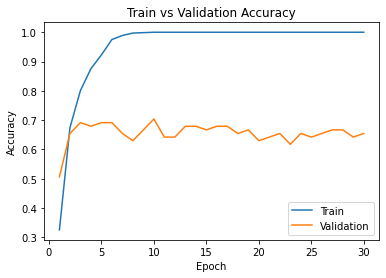

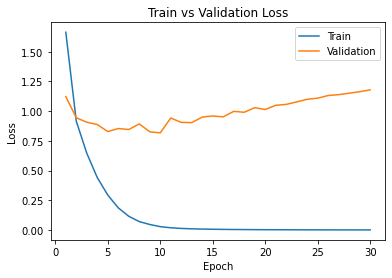

In [ ]:
itr = 201
batch_size = 64
hidden_size = 150
lr_rate = 0.0005
n_layers = 1
dr = 0


train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


params_model={
        "num_classes": num_classes,
        "dr_rate": dr,
        "pretrained" : True,
        "rnn_num_layers": 1,
        "rnn_hidden_size": hidden_size,}

model_1 = LSTM_Model_reverse(params_model)  
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_1 = model_1.to(device)

train_my(model_1, train_loader, test_loader, name='{}_LSTM2_rev_best_h{}_n{}_dr{}'.format(itr, hidden_size, n_layers, dr), 
         batch_size=batch_size, learning_rate=lr_rate, num_epochs=30)


Epoch 1: Train acc: 0.41217150760719223, Train loss: 1.6111606100331182 |Validation acc: 0.7160493827160493, Validation loss: 1.0171231031417847
Epoch 2: Train acc: 0.7496542185338866, Train loss: 0.6776582235875337 |Validation acc: 0.6419753086419753, Validation loss: 0.9303443233172098
Epoch 3: Train acc: 0.8865836791147994, Train loss: 0.38859947155351227 |Validation acc: 0.7037037037037037, Validation loss: 0.8191600243250529
Epoch 4: Train acc: 0.9280774550484094, Train loss: 0.23941533008347388 |Validation acc: 0.7037037037037037, Validation loss: 0.7953455448150635
Epoch 5: Train acc: 0.9847856154910097, Train loss: 0.11415961271394855 |Validation acc: 0.7654320987654321, Validation loss: 0.7391301194826762
Epoch 6: Train acc: 0.9986168741355463, Train loss: 0.05059992214259894 |Validation acc: 0.6790123456790124, Validation loss: 0.7695388396581014
Epoch 7: Train acc: 1.0, Train loss: 0.02448480928559666 |Validation acc: 0.7037037037037037, Validation loss: 0.7833868265151978
E

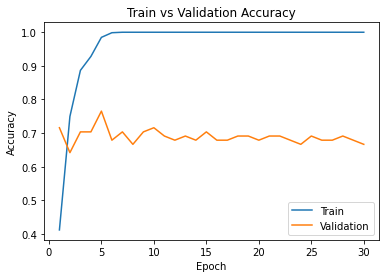

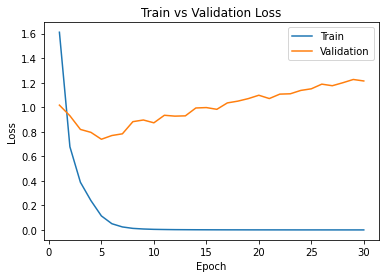

In [ ]:
itr = 201
batch_size = 32
hidden_size = 256
lr_rate = 0.0005
n_layers = 2
dr = 0.01


train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


params_model={
        "num_classes": num_classes,
        "dr_rate": dr,
        "pretrained" : True,
        "rnn_num_layers": 1,
        "rnn_hidden_size": hidden_size,}

model_1 = LSTM_Model_reverse(params_model)  
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_1 = model_1.to(device)

train_my(model_1, train_loader, test_loader, name='{}_LSTM2_rev_best_h{}_n{}_dr{}'.format(itr, hidden_size, n_layers, dr), 
         batch_size=batch_size, learning_rate=lr_rate, num_epochs=30)


## Testing/ Deploying Models on New Unseen Test Data

We've finished training Three different models. Now, it's time to deploy the model on a new test videos. We need to instantiate an object of the model class. we can do this by calling the get_model function defined in the helper section. Then, we will load the trained weights into the model.

### Verifying for Model 3: Feature Learning + LSTM + Self Attention

In [ ]:
def get_accuracy_deploy(model, loader, criterion):
    #Function to calculate accuracy of the classification model
    
    map_dict = ['laugh','run','shake_hands','turn']
    
    correct = 0
    total = 0
    total_loss = 0
    i = 0

    for imgs, labels in loader:
        
        #To Enable GPU Usage
        if use_cuda and torch.cuda.is_available():
            imgs = imgs.cuda()
            labels = labels.cuda()
        
        output = model(imgs)
        
        #select index with maximum prediction score
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += imgs.shape[0]

        loss = criterion(output, labels)
        total_loss += loss.item()
        i+=1
        
    loss = float(total_loss) / (i)
    acc = correct/total
    
    
    
    return loss, acc, [map_dict[i] for i in pred.T.cpu().numpy()[0]]


In [ ]:
path2data = "./trial_30_03"
test_sub_folder = "testdata"
test_sub_folder_jpg = "testdata_jpg"
test_path2aCatgs = os.path.join(path2data, test_sub_folder)

test_listOfCategories = os.listdir(test_path2aCatgs)
test_listOfCategories, len(test_listOfCategories)

(['laugh', 'run', 'shake_hands', 'turn'], 4)

In [ ]:
extension = ".avi"
n_frames = 16
for root, dirs, files in os.walk(test_path2aCatgs, topdown=False):
    for name in files:
        
        if extension not in name:
            continue
        path2vid = os.path.join(root, name)
        frames, vlen = get_frames(path2vid, n_frames= n_frames)
        path2store = path2vid.replace(test_sub_folder, test_sub_folder_jpg)
        path2store = path2store.replace(extension, "")
        print(path2store)
        os.makedirs(path2store, exist_ok= True)
        store_frames(frames, path2store)
    print("-"*50) 

./trial_30_03\testdata_jpg\laugh\1_laugh
./trial_30_03\testdata_jpg\laugh\2_laugh
./trial_30_03\testdata_jpg\laugh\3_laugh
./trial_30_03\testdata_jpg\laugh\4_laugh
./trial_30_03\testdata_jpg\laugh\5_laugh
--------------------------------------------------
./trial_30_03\testdata_jpg\run\1_run
./trial_30_03\testdata_jpg\run\2_run
./trial_30_03\testdata_jpg\run\3_run
./trial_30_03\testdata_jpg\run\4_run
./trial_30_03\testdata_jpg\run\5_run
--------------------------------------------------
./trial_30_03\testdata_jpg\shake_hands\AnyConv.com__7hDv
./trial_30_03\testdata_jpg\shake_hands\AnyConv.com__AdmirableUniqueFrogmouth-size_restricted
./trial_30_03\testdata_jpg\shake_hands\AnyConv.com__donald-trump-justin-trudeau
./trial_30_03\testdata_jpg\shake_hands\AnyConv.com__giphy-downsized-large
./trial_30_03\testdata_jpg\shake_hands\AnyConv.com__giphy-downsized
--------------------------------------------------
./trial_30_03\testdata_jpg\turn\AnyConv.com__5gjw
./trial_30_03\testdata_jpg\turn\Any

In [ ]:
test_path2ajpgs = os.path.join(path2data, test_sub_folder_jpg)
test_all_vids, test_all_labels, test_catgs = get_vids(test_path2ajpgs) 

test_labels_dict = {}
ind = 0
for uc in test_catgs:
    test_labels_dict[uc] = ind
    ind+=1
    
print("The labels of the test dataset are:")
test_labels_dict

The labels of the test dataset are:


{'laugh': 0, 'run': 1, 'shake_hands': 2, 'turn': 3}

In [ ]:
num_classes = 4

test_unique_ids = [id_ for id_, label in zip(test_all_vids,test_all_labels) if test_labels_dict[label]<num_classes]
test_unique_labels = [label for id_, label in zip(test_all_vids,test_all_labels) if test_labels_dict[label]<num_classes]
print("Length of unique ids: {}, Length of unique labels: {}".format(len(test_unique_ids),len(test_unique_labels)))

Length of unique ids: 20, Length of unique labels: 20


In [ ]:
n_frames = 16
h, w = 64, 64
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

test_test_transformer = transforms.Compose([
            transforms.Resize((h,w)),
            transforms.ToTensor(),
            transforms.Normalize(mean, std),
            ]) 

test_test_ds = VideoDataset(ids= test_unique_ids, labels= test_unique_labels, transform= test_test_transformer)



In [ ]:

itr = 201
batch_size = 64
hidden_size = 150
lr_rate = 0.0005
n_layers = 1
dr = 0


params_model={
        "num_classes": num_classes,
        "dr_rate": dr,
        "pretrained" : True,
        "rnn_num_layers": 1,
        "rnn_hidden_size": hidden_size,}

model_1 = LSTM_Model_reverse(params_model)  
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_1 = model_1.to(device)



model_path = get_model_name('{}_LSTM2_rev_best_h{}_n{}_dr{}'.format(itr, hidden_size, n_layers, dr), batch_size=batch_size, learning_rate=lr_rate, epoch=9)

state = torch.load(model_path)
model_1.load_state_dict(state)


<All keys matched successfully>

In [ ]:
test_test_dl = DataLoader(test_test_ds, batch_size= 2048, shuffle=False, collate_fn= collate_fn_rnn) 

In [ ]:
baseModel_c = models.resnet18(pretrained=True)
baseModel_c.fc = Identity()
timesteps=16
from tqdm import tqdm
for xb1, yb1 in tqdm(test_test_dl):
    b_z, ts, c, h, w = xb1.shape
    ch = 0
    
    for ii in range(0, ts):
        if ch==0:
            y_tr = baseModel_c((xb1[:,ii])).unsqueeze(dim=1)
            
        else:
            
            y1_tr = baseModel_c((xb1[:,ii])).unsqueeze(dim=1)
            y_tr = torch.cat((y_tr,y1_tr), dim=1)

        ch+=1
    ybb_tr = yb1

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.48s/it]


In [ ]:
print('Testing Features shape: {}, Labels shape: {}'.format(y_tr.shape, ybb_tr.shape))
torch.save(y_tr, './trial_30_03/features/testing_features_4.pt')
torch.save(ybb_tr, './trial_30_03/features/testing_labels_4.pt')

Testing Features shape: torch.Size([20, 16, 512]), Labels shape: torch.Size([20])


In [ ]:
from torch.utils.data import TensorDataset, Dataset

load_testing_features = torch.load('./trial_30_03/features/testing_features_4.pt')
load_testing_labels = torch.load('./trial_30_03/features/testing_labels_4.pt')


testing_dataset = TensorDataset(load_testing_features, load_testing_labels)
testing_loader = torch.utils.data.DataLoader(testing_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
testing_loader = torch.utils.data.DataLoader(testing_dataset, batch_size=batch_size, shuffle=False)

criterion = nn.CrossEntropyLoss()
testing_ls, testing_ac, predictions = get_accuracy_deploy(model_1, loader=testing_loader, criterion=criterion)

# Print Predictions
print('\033[1m'+"The loss for the newly-selected test dataset: ", testing_ls)
print('\033[1m'+"The accuracy for the newly-selected test dataset: ", testing_ac)

The loss for the newly-selected test dataset:  0.6565679907798767
The accuracy for the newly-selected test dataset:  0.7


Predicted Label: turn | Original Label: laugh


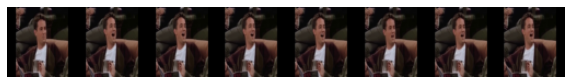

Predicted Label: laugh | Original Label: laugh


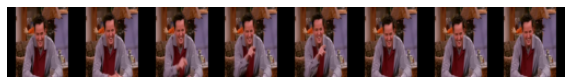

Predicted Label: laugh | Original Label: laugh


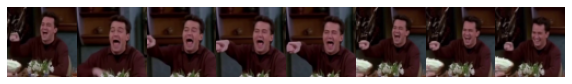

Predicted Label: turn | Original Label: laugh


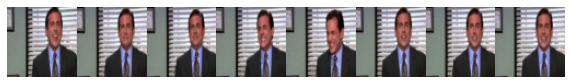

Predicted Label: laugh | Original Label: laugh


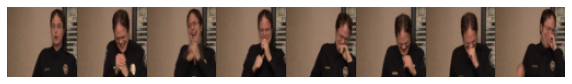

Predicted Label: run | Original Label: run


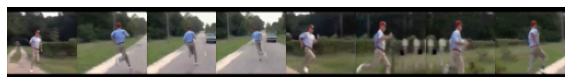

Predicted Label: run | Original Label: run


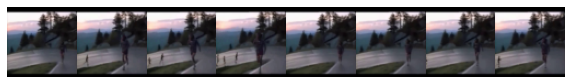

Predicted Label: run | Original Label: run


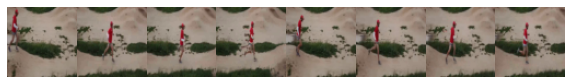

Predicted Label: run | Original Label: run


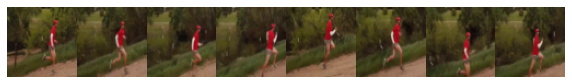

Predicted Label: run | Original Label: run


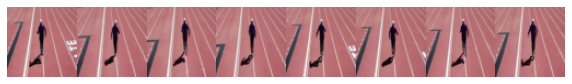

Predicted Label: shake_hands | Original Label: shake_hands


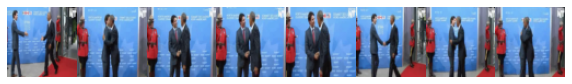

Predicted Label: turn | Original Label: shake_hands


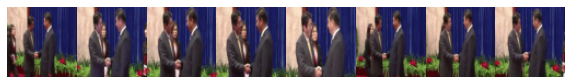

Predicted Label: shake_hands | Original Label: shake_hands


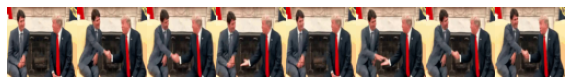

Predicted Label: run | Original Label: shake_hands


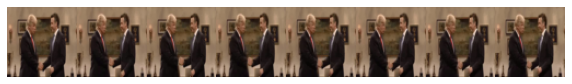

Predicted Label: shake_hands | Original Label: shake_hands


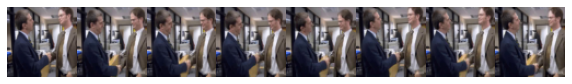

Predicted Label: turn | Original Label: turn


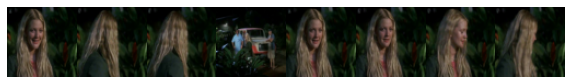

Predicted Label: run | Original Label: turn


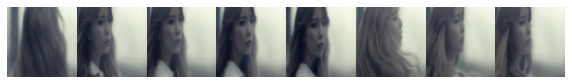

Predicted Label: shake_hands | Original Label: turn


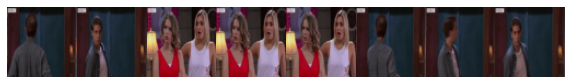

Predicted Label: turn | Original Label: turn


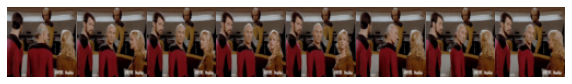

Predicted Label: turn | Original Label: turn


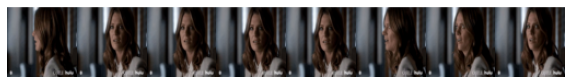

In [ ]:
map_dict = ['laugh','run','shake_hands','turn']
labels_ = []
for i in range(20):

    imgs, label = test_test_ds[i]
    imgs.shape, label, torch.min(imgs), torch.max(imgs)

    plt.figure(figsize=(20,20))
    plt.subplots_adjust(wspace=0, hspace=0)
    for ii,img in enumerate(imgs[::2]):
        
        plt.subplot(1,16,ii+1)
        plt.imshow(denormalize(img, mean, std))
        plt.axis("off")
    
    labels_.append(label)
    print('\033[1m'+"Predicted Label:", predictions[i], "| Original Label:", map_dict[label])  
    plt.show()
      
    

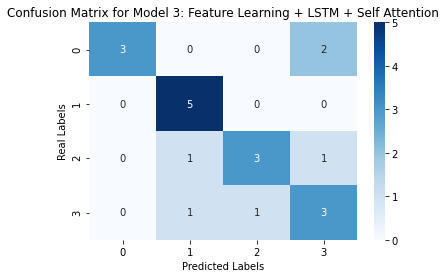

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

predictions_ = [map_dict.index(i) for i in predictions]

matrix_ = confusion_matrix(labels_, predictions_)

ax = sns.heatmap(matrix_, annot=True, cmap='Blues')

ax.set_title('Confusion Matrix for Model 3: Feature Learning + LSTM + Self Attention');
ax.set_xlabel('Predicted Labels')
ax.set_ylabel('Real Labels');
plt.show()


### Verifying for Model 1: ResNet-18 + LSTM​

In [ ]:
num_classes = 4
params_model={
        "num_classes": num_classes,
        "dr_rate": 0.1,
        "pretrained" : True,
        "rnn_num_layers": 1,
        "rnn_hidden_size": 100,}

model = Resnt18Rnn(params_model)  
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

n_frames=16
best_ep = 43
best_bs = 16
best_lr = 0.0001
model_path = get_model_name('CNN_LSTM', batch_size=best_bs, learning_rate=best_lr, epoch=best_ep)

state = torch.load(model_path)
model.load_state_dict(state)

<All keys matched successfully>

In [ ]:

criterion = nn.CrossEntropyLoss()
testing_ls, testing_ac, predictions = get_accuracy_deploy(model, loader=test_test_dl, criterion=criterion)


# Print Predictions
print('\033[1m'+"The loss for the newly-selected test dataset: ", testing_ls)
print('\033[1m'+"The accuracy for the newly-selected test dataset: ", testing_ac)



The loss for the newly-selected test dataset:  0.7835025191307068
The accuracy for the newly-selected test dataset:  0.8


Predicted Label: turn | Original Label: laugh


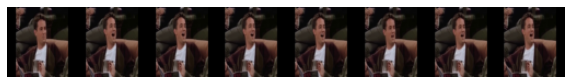

Predicted Label: shake_hands | Original Label: laugh


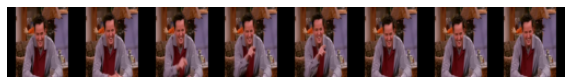

Predicted Label: laugh | Original Label: laugh


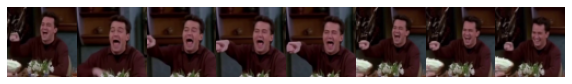

Predicted Label: laugh | Original Label: laugh


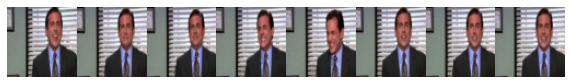

Predicted Label: turn | Original Label: laugh


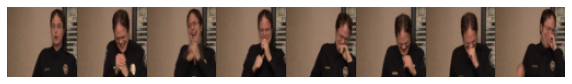

Predicted Label: run | Original Label: run


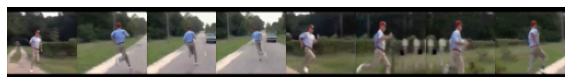

Predicted Label: run | Original Label: run


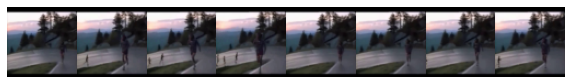

Predicted Label: run | Original Label: run


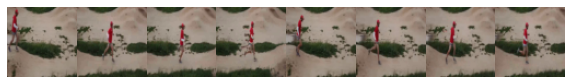

Predicted Label: run | Original Label: run


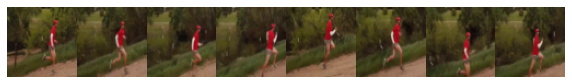

Predicted Label: run | Original Label: run


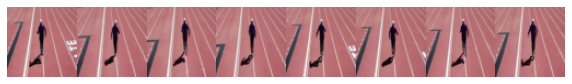

Predicted Label: shake_hands | Original Label: shake_hands


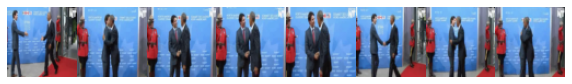

Predicted Label: shake_hands | Original Label: shake_hands


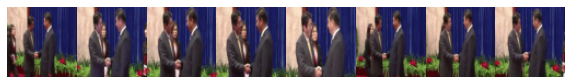

Predicted Label: shake_hands | Original Label: shake_hands


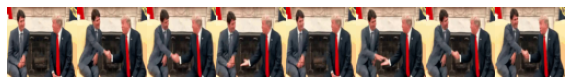

Predicted Label: shake_hands | Original Label: shake_hands


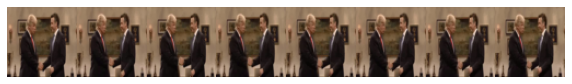

Predicted Label: shake_hands | Original Label: shake_hands


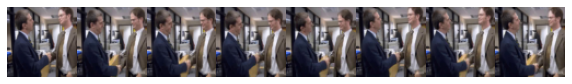

Predicted Label: turn | Original Label: turn


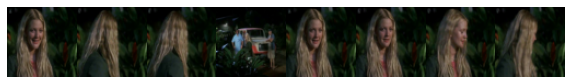

Predicted Label: laugh | Original Label: turn


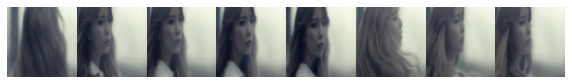

Predicted Label: turn | Original Label: turn


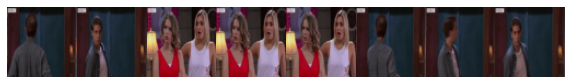

Predicted Label: turn | Original Label: turn


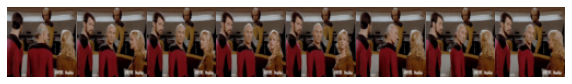

Predicted Label: turn | Original Label: turn


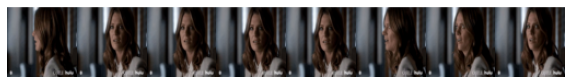

In [ ]:
map_dict = ['laugh','run','shake_hands','turn']
labels_ = []
for i in range(20):

    imgs, label = test_test_ds[i]
    imgs.shape, label, torch.min(imgs), torch.max(imgs)

    plt.figure(figsize=(20,20))
    plt.subplots_adjust(wspace=0, hspace=0)
    for ii,img in enumerate(imgs[::2]):
        
        plt.subplot(1,16,ii+1)
        plt.imshow(denormalize(img, mean, std))
        plt.axis("off")
    
    labels_.append(label)
    print('\033[1m'+"Predicted Label:", predictions[i], "| Original Label:", map_dict[label])   
    plt.show()
      
    

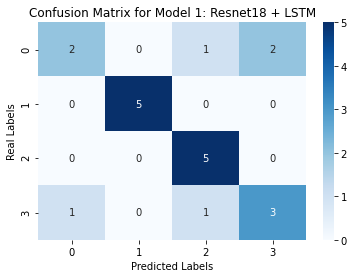

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

predictions_ = [map_dict.index(i) for i in predictions]

matrix_ = confusion_matrix(labels_, predictions_)

ax = sns.heatmap(matrix_, annot=True, cmap='Blues')

ax.set_title('Confusion Matrix for Model 1: Resnet18 + LSTM');
ax.set_xlabel('Predicted Labels')
ax.set_ylabel('Real Labels');
plt.show()


### Verifying for Model 2: ResNet-18 (3D CNN)

In [ ]:
# Defined the model
model_3 = models.video.r3d_18(pretrained=True, progress=False)

# Extracted the number of input features to the linear layer in the architecture
num_features = model_3.fc.in_features

# Updated the linear layer to adjust for the output class
model_3.fc = nn.Linear(num_features, num_classes)

# Moved the model to the device (cpu or gpu)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_3 = model_3.to(device)

# Defined the parameters for loading the model state dictionary
n_frames=16
best_ep = 49
best_bs = 16
best_lr = 0.0015
model_path = get_model_name('VideoResNet', batch_size=best_bs, learning_rate=best_lr, epoch=best_ep)

# Loaded the best model weights
state = torch.load(model_path)
model_3.load_state_dict(state)

<All keys matched successfully>

In [ ]:
# Defining the pixel size
h, w = 64, 64

# Parameters for normalizing the data
mean = [0.43216, 0.394666, 0.37645]
std = [0.22803, 0.22145, 0.216989]

# Define Transforms
test_test_transformer_3d = transforms.Compose([
            transforms.Resize((h,w)),
            transforms.ToTensor(),
            transforms.Normalize(mean, std),
            ]) 

# Load the test data
test_test_ds_3d = VideoDataset(ids= test_unique_ids, labels= test_unique_labels, transform= test_test_transformer_3d)
test_test_dl_3d = DataLoader(test_test_ds_3d, batch_size= 2048, shuffle=False, collate_fn= collate_fn_r3d_18) 

In [ ]:
# Define Criterion
criterion = nn.CrossEntropyLoss()

# Generate Predictions
testing_ls, testing_ac, predictions = get_accuracy_deploy(model_3, loader=test_test_dl_3d, criterion=criterion)

# Print Predictions
print('\033[1m'+"The loss for the newly-selected test dataset: ", testing_ls)
print('\033[1m'+"The accuracy for the newly-selected test dataset: ", testing_ac)



The loss for the newly-selected test dataset:  0.9212425947189331
The accuracy for the newly-selected test dataset:  0.85


Printing first 8 frames for the videos shown in the presentation
--------------------------------------------------------------------------
Predicted Label: laugh | Original Label: laugh


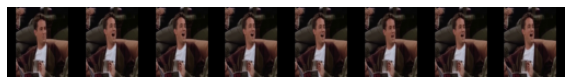

Predicted Label: laugh | Original Label: laugh


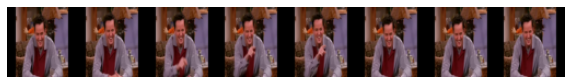

Predicted Label: laugh | Original Label: laugh


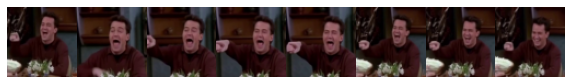

Predicted Label: turn | Original Label: laugh


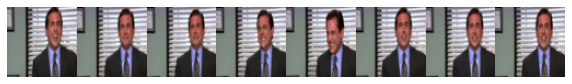

Predicted Label: turn | Original Label: laugh


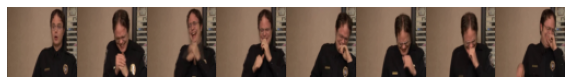

Predicted Label: run | Original Label: run


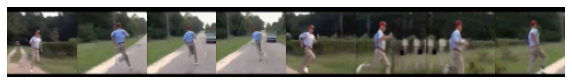

Predicted Label: run | Original Label: run


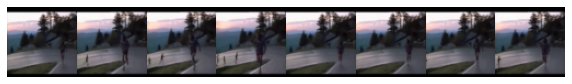

Predicted Label: run | Original Label: run


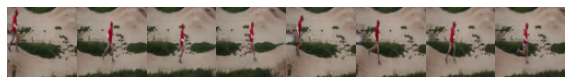

Predicted Label: run | Original Label: run


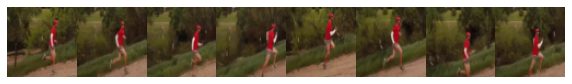

Predicted Label: shake_hands | Original Label: run


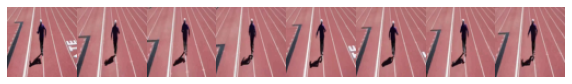

Predicted Label: shake_hands | Original Label: shake_hands


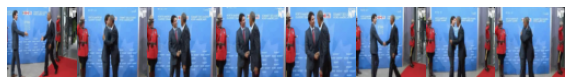

Predicted Label: shake_hands | Original Label: shake_hands


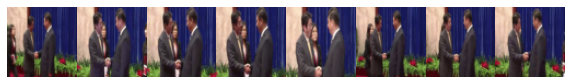

Predicted Label: shake_hands | Original Label: shake_hands


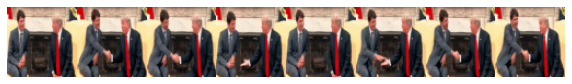

Predicted Label: shake_hands | Original Label: shake_hands


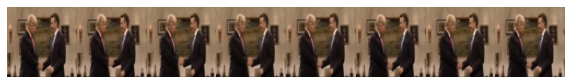

Predicted Label: shake_hands | Original Label: shake_hands


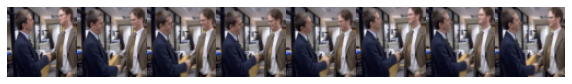

Predicted Label: turn | Original Label: turn


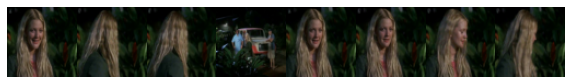

Predicted Label: turn | Original Label: turn


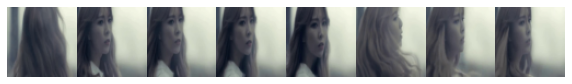

Predicted Label: turn | Original Label: turn


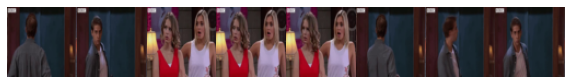

Predicted Label: turn | Original Label: turn


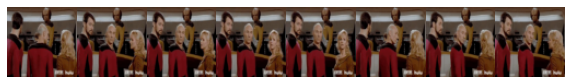

Predicted Label: turn | Original Label: turn


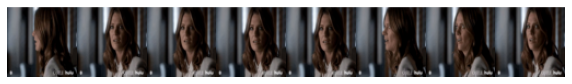

In [ ]:
# Mapping dictionary
map_dict = ['laugh','run','shake_hands','turn']
labels_ = []

# Print Frames (first 8 frames)
print("Printing first 8 frames for the videos shown in the presentation")
print("-"*74)
for i in range(20):

    imgs, label = test_test_ds_3d[i]
    imgs.shape, label, torch.min(imgs), torch.max(imgs)
    
    if True: #provide conditions for plotting any particular sample
        plt.figure(figsize=(20,20))
        plt.subplots_adjust(wspace=0, hspace=0)
        for ii,img in enumerate(imgs[::2]):

            plt.subplot(1,16,ii+1)
            plt.imshow(denormalize(img, mean, std))
            plt.axis("off")

        
        print('\033[1m'+"Predicted Label:", predictions[i], "| Original Label:", map_dict[label])  
        plt.show()
    labels_.append(label)

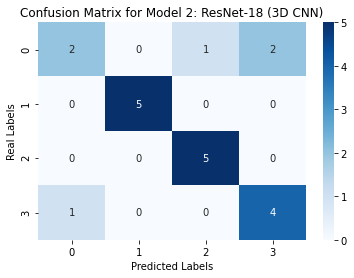

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

predictions_ = [map_dict.index(i) for i in predictions]

matrix_ = confusion_matrix(labels_, predictions_)

ax = sns.heatmap(matrix_, annot=True, cmap='Blues')

ax.set_title('Confusion Matrix for Model 2: ResNet-18 (3D CNN)');
ax.set_xlabel('Predicted Labels')
ax.set_ylabel('Real Labels');
plt.show()


## Discussion

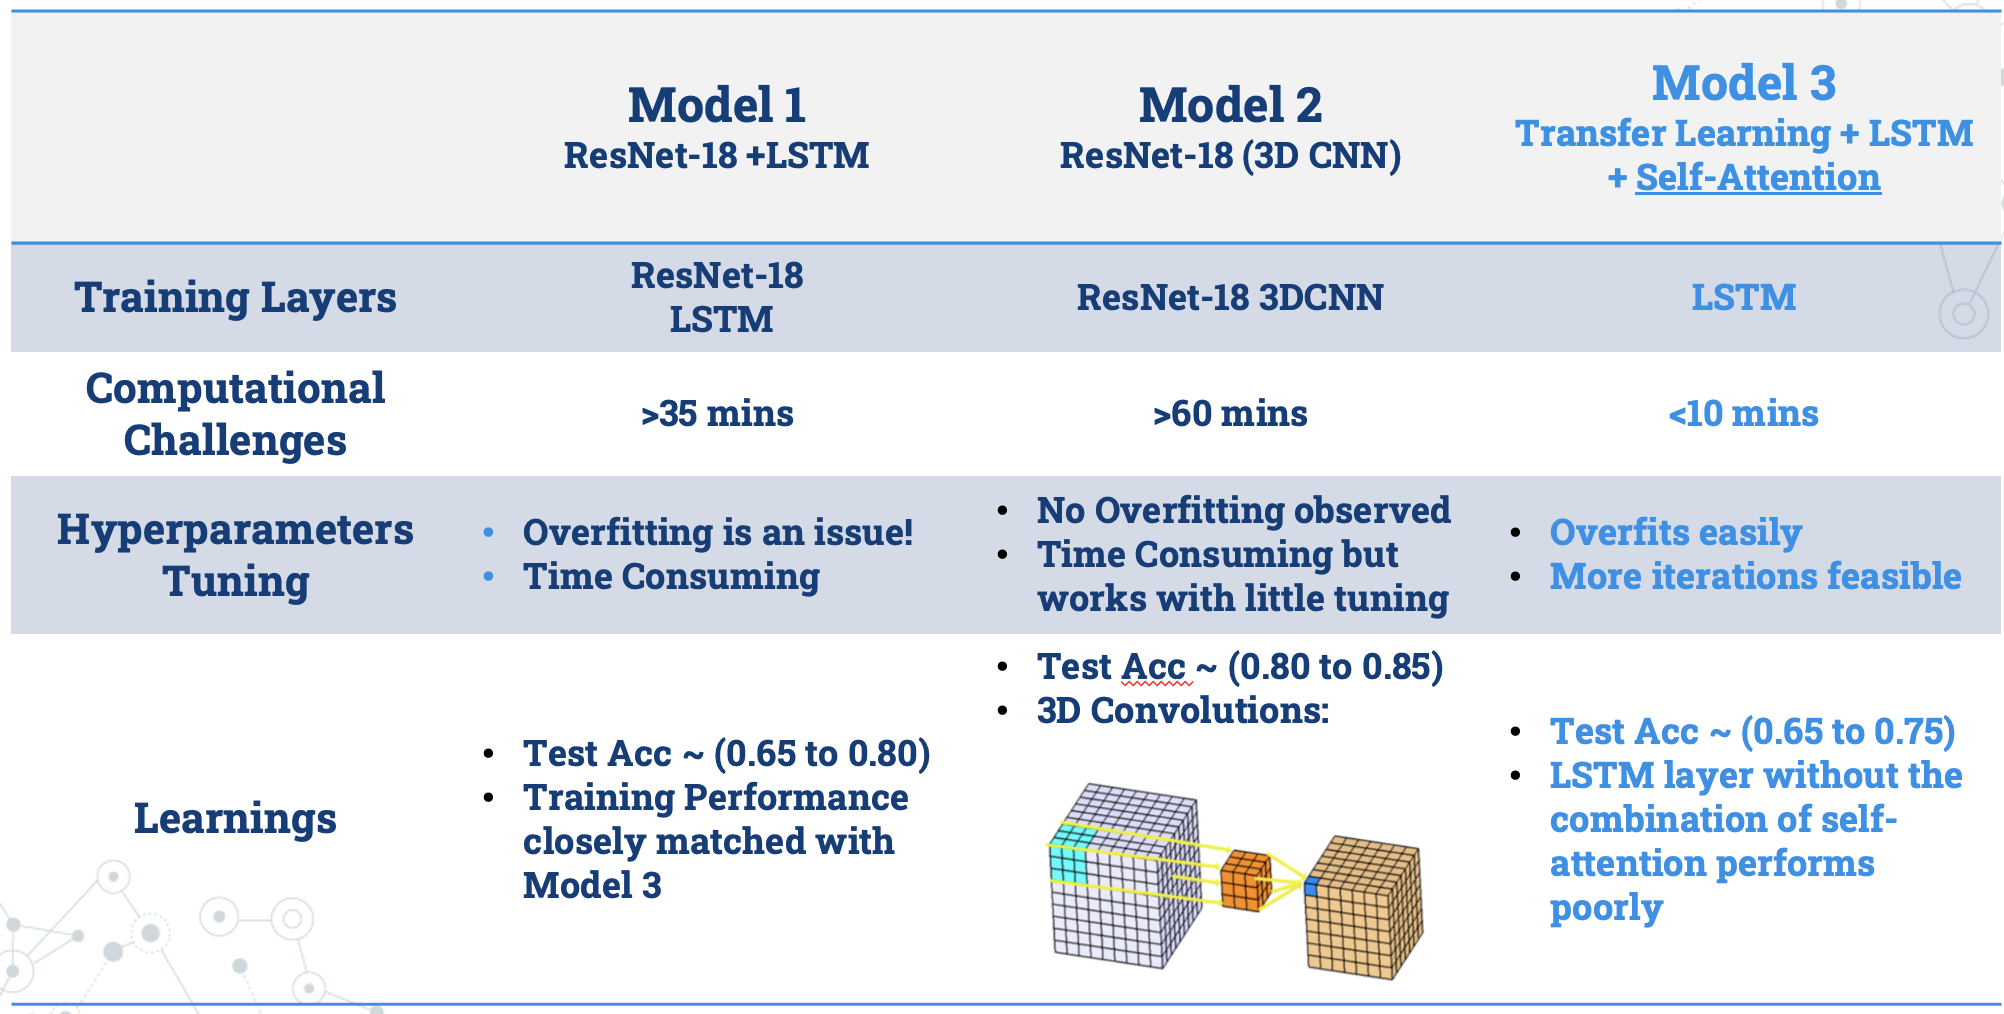

As highlighted previously, the 3D CNN model outperformed the other models but was computationally expensive. On the other hand, the first model took less amount of training time. However, it still was extremely difficult to perform multiple iterations. To overcome this, a new model was developed with a combination of LSTM and a self-attention mechanism. Without, attention the LSTM model seemed to perform poorly. The target was to attain at least a comparable performance to the first model with a lower training time which was somewhat fulfilled but still faced overfitting issues. Overall, based on the comparisons among these models, the 3D CNN model should be preferred wherever possible. If computation power is an issue, Model 3 could be explored and developed further.




## Real-life Usecases
- This Model can be used for any scenario, for any kind of video classification provided with the Training data for the problem.
- Can be applied in a hazardous environment like industries where we can alarm the supervisor if a worker is not using proper safety measures.
- Can be used to add redundancy in safety features like smoke detections, fire detections, etc.
- Can be applied to ensure the functioning of the road manholes.
- Can be used by the physiotherapists to ensure the correct postures of the patients virtually.

## Conclusion

The main objective of this project was to learn how to implement a video classification problem. It can be applied in a variety of application domains including its application as a redundancy system in safety equipment such as smoke detection on airplanes and as a classification system for observing the functioning of road manholes and many more…

As per the above steps, we can observe that the models which we have created have performed well on the video classification. We were impressed with the results reporting that for the ResNet-18 + 3D-CNN model.

## References
1. MIE1517 Lab Assignments
2. https://www.packtpub.com/data/pytorch-computer-vision-cookbook?utm_source=github&utm_medium=repository&utm_campaign=9781838644833
3. https://colab.research.google.com/github/keras-team/keras-io/blob/master/examples/vision/ipynb/video_classification.ipynb
4. https://serre-lab.clps.brown.edu/resource/hmdb-a-large-human-motion-database/
5. https://gifer.com/en/7IsD
6. https://paperswithcode.com/lib/torchvision/resnet
7. https://paperswithcode.com/model/resnet-3d?variant=resnet-3d-18
8. http://www.d2l.ai/chapter_multilayer-perceptrons/backprop.html
9. https://www.deeplearningbook.org/
